In [1]:
!pip install mlflow -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 75.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.0 MB/s eta 0:00:00


In [2]:
import mlflow
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from mlflow.tracking import MlflowClient
import warnings
warnings.filterwarnings('ignore')

print("✅ Installation completed!")


✅ Installation completed!


In [7]:
df = pd.read_csv('/kaggle/input/train-csv/train.csv')

# معالجة الـ label - تحويل "No Fit" لـ 0 و أي حاجة تانية لـ 1
def process_label(label):
    if pd.isna(label):
        return 0
    label_str = str(label).strip().lower()
    if label_str in ['no fit', 'no', '0', 'false']:
        return 0
    else:
        return 1

df['label'] = df['label'].apply(process_label)

print(f"📊 Dataset Info:")
print(f"   Total samples: {len(df)}")
print(f"   Columns: {df.columns.tolist()}")
print(f"\n📋 Label distribution:")
print(df['label'].value_counts())

# تنظيف النصوص (إزالة القيم الفاضية)
df = df.dropna(subset=['resume_text', 'job_description_text'])
print(f"\n✅ After cleaning: {len(df)} samples")

# تقسيم الداتا
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"\n✅ Data split:")
print(f"   Training: {len(train_df)} samples")
print(f"   Testing: {len(test_df)} samples")
print(f"\n📊 Test set label distribution:")
print(test_df['label'].value_counts())


📊 Dataset Info:
   Total samples: 6241
   Columns: ['resume_text', 'job_description_text', 'label']

📋 Label distribution:
label
0    3143
1    3098
Name: count, dtype: int64

✅ After cleaning: 6241 samples

✅ Data split:
   Training: 4992 samples
   Testing: 1249 samples

📊 Test set label distribution:
label
0    629
1    620
Name: count, dtype: int64


In [8]:
mlflow.set_tracking_uri("/kaggle/working/mlruns")
mlflow.set_experiment("CV-Job-Matching-Final")

def calculate_similarity(cv_text, jd_text, model, tokenizer, device):
    """حساب cosine similarity بين CV و JD"""
    try:
        # تنظيف النص
        cv_text = str(cv_text).strip()
        jd_text = str(jd_text).strip()
        
        # Tokenization
        cv_inputs = tokenizer(
            cv_text,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding='max_length'
        ).to(device)
        
        jd_inputs = tokenizer(
            jd_text,
            return_tensors='pt',
            truncation=True,
            max_length=512,
            padding='max_length'
        ).to(device)
        
        # Get embeddings
        with torch.no_grad():
            cv_output = model(**cv_inputs)
            jd_output = model(**jd_inputs)
            
            # استخدام [CLS] token embedding
            cv_emb = cv_output.last_hidden_state[:, 0, :].cpu().numpy()
            jd_emb = jd_output.last_hidden_state[:, 0, :].cpu().numpy()
        
        # Cosine similarity
        dot_product = np.dot(cv_emb, jd_emb.T)
        norm_cv = np.linalg.norm(cv_emb)
        norm_jd = np.linalg.norm(jd_emb)
        similarity = dot_product / (norm_cv * norm_jd + 1e-8)
        
        return float(similarity[0][0])
    
    except Exception as e:
        print(f"⚠️ Error in similarity calculation: {str(e)}")
        return 0.0


def evaluate_model(model_name, model_path, test_df):
    """تقييم موديل واحد"""
    
    print(f"\n{'='*70}")
    print(f"🔍 Testing Model: {model_name}")
    print(f"{'='*70}")
    
    with mlflow.start_run(run_name=model_name):
        
        # Log parameters
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("model_path", model_path)
        mlflow.log_param("test_size", len(test_df))
        
        # Load model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"📱 Using device: {device}")
        
        try:
            print("📥 Loading tokenizer and model...")
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            model = AutoModel.from_pretrained(model_path)
            model.to(device)
            model.eval()
            print("✅ Model loaded successfully!")
        except Exception as e:
            print(f"❌ Failed to load model: {str(e)}")
            return None
        
        # Evaluation
        predictions = []
        true_labels = []
        similarities = []
        errors = 0
        
        print(f"🔄 Evaluating on {len(test_df)} samples...")
        
        for idx, row in test_df.iterrows():
            try:
                cv_text = row['resume_text']
                jd_text = row['job_description_text']
                true_label = int(row['label'])
                
                # Check for empty texts
                if pd.isna(cv_text) or pd.isna(jd_text) or len(str(cv_text).strip()) == 0 or len(str(jd_text).strip()) == 0:
                    errors += 1
                    continue
                
                # Calculate similarity
                sim = calculate_similarity(cv_text, jd_text, model, tokenizer, device)
                similarities.append(sim)
                
                # Prediction (threshold = 0.5)
                pred = 1 if sim > 0.5 else 0
                predictions.append(pred)
                true_labels.append(true_label)
                
                # Progress update
                if (idx + 1) % 20 == 0:
                    print(f"   ✓ Progress: {idx + 1}/{len(test_df)} samples processed...")
                
            except Exception as e:
                errors += 1
                if errors <= 3:
                    print(f"   ⚠️ Error at row {idx}: {str(e)}")
                continue
        
        # Check if we have results
        if len(predictions) == 0:
            print(f"❌ No valid predictions for {model_name}")
            return None
        
        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions, zero_division=0)
        recall = recall_score(true_labels, predictions, zero_division=0)
        f1 = f1_score(true_labels, predictions, zero_division=0)
        avg_sim = np.mean(similarities)
        std_sim = np.std(similarities)
        
        # Log to MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("avg_similarity", avg_sim)
        mlflow.log_metric("std_similarity", std_sim)
        mlflow.log_metric("successful_samples", len(predictions))
        mlflow.log_metric("error_count", errors)
        
        # Print results
        print(f"\n📊 Results for {model_name}:")
        print(f"   {'─'*60}")
        print(f"   ✓ Processed: {len(predictions)}/{len(test_df)} samples")
        print(f"   ✓ Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"   ✓ Precision:     {precision:.4f}")
        print(f"   ✓ Recall:        {recall:.4f}")
        print(f"   ✓ F1 Score:      {f1:.4f}")
        print(f"   ✓ Avg Similarity: {avg_sim:.4f} ± {std_sim:.4f}")
        if errors > 0:
            print(f"   ⚠️ Errors:        {errors}")
        print(f"   {'─'*60}")
        
        # Save sample predictions
        sample_results = pd.DataFrame({
            'true_label': true_labels[:10],
            'prediction': predictions[:10],
            'similarity': [f"{s:.4f}" for s in similarities[:10]],
            'match': ['✓' if t == p else '✗' for t, p in zip(true_labels[:10], predictions[:10])]
        })
        print(f"\n📋 Sample Predictions (first 10):")
        print(sample_results.to_string(index=False))
        
        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'avg_similarity': avg_sim,
            'std_similarity': std_sim,
            'successful_samples': len(predictions),
            'total_samples': len(test_df),
            'errors': errors
        }

print("✅ Functions defined successfully!")

2025/12/07 19:55:02 INFO mlflow.tracking.fluent: Experiment with name 'CV-Job-Matching-Final' does not exist. Creating a new experiment.


✅ Functions defined successfully!


In [9]:
models_to_test = {
    'JobBERT': 'jjzha/jobbert_knowledge_extraction',
    'MiniLM': 'sentence-transformers/all-MiniLM-L6-v2',
    'MPNet': 'sentence-transformers/all-mpnet-base-v2',
    'BGE-Base': 'BAAI/bge-base-en-v1.5'
}

all_results = []

print("\n" + "="*80)
print("🚀 STARTING MODEL COMPARISON EXPERIMENTS")
print("="*80)

for model_name, model_path in models_to_test.items():
    try:
        result = evaluate_model(model_name, model_path, test_df)
        
        if result is not None:
            all_results.append(result)
            
        # Clean up memory
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"\n❌ Fatal error with {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print("✅ ALL EXPERIMENTS COMPLETED!")
print("="*80)



🚀 STARTING MODEL COMPARISON EXPERIMENTS

🔍 Testing Model: JobBERT
📱 Using device: cuda
📥 Loading tokenizer and model...


Some weights of BertModel were not initialized from the model checkpoint at jjzha/jobbert_knowledge_extraction and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!
🔄 Evaluating on 1249 samples...
   ✓ Progress: 1960/1249 samples processed...
   ✓ Progress: 4120/1249 samples processed...
   ✓ Progress: 3540/1249 samples processed...
   ✓ Progress: 3220/1249 samples processed...
   ✓ Progress: 5160/1249 samples processed...
   ✓ Progress: 20/1249 samples processed...
   ✓ Progress: 1120/1249 samples processed...
   ✓ Progress: 4260/1249 samples processed...
   ✓ Progress: 5240/1249 samples processed...
   ✓ Progress: 4880/1249 samples processed...
   ✓ Progress: 3940/1249 samples processed...
   ✓ Progress: 1480/1249 samples processed...
   ✓ Progress: 4460/1249 samples processed...
   ✓ Progress: 2940/1249 samples processed...
   ✓ Progress: 560/1249 samples processed...
   ✓ Progress: 460/1249 samples processed...
   ✓ Progress: 500/1249 samples processed...
   ✓ Progress: 3700/1249 samples processed...
   ✓ Progress: 5180/1249 samples processed...
   ✓ Progress: 4840/1249 samples processed...
   ✓ Progress: 5140/1249

In [10]:
if len(all_results) > 0:
    results_df = pd.DataFrame(all_results)
    results_df = results_df.sort_values('f1_score', ascending=False).reset_index(drop=True)
    
    print("\n" + "="*80)
    print("🏆 FINAL COMPARISON RESULTS")
    print("="*80 + "\n")
    
    # عرض جدول النتائج
    display_cols = ['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'avg_similarity']
    print(results_df[display_cols].to_string(index=False))
    
    # حفظ النتائج
    results_df.to_csv('final_model_comparison.csv', index=False)
    print("\n✅ Results saved to: final_model_comparison.csv")
    
    # تحديد أفضل موديل
    best_row = results_df.iloc[0]
    print(f"\n{'='*80}")
    print("🥇 BEST MODEL")
    print(f"{'='*80}")
    print(f"   Model:      {best_row['model_name']}")
    print(f"   Accuracy:   {best_row['accuracy']:.4f} ({best_row['accuracy']*100:.2f}%)")
    print(f"   F1 Score:   {best_row['f1_score']:.4f}")
    print(f"   Precision:  {best_row['precision']:.4f}")
    print(f"   Recall:     {best_row['recall']:.4f}")
    print(f"   Avg Sim:    {best_row['avg_similarity']:.4f}")
    print(f"{'='*80}\n")
    
else:
    print("\n❌ No successful results!")
    print("Please check the error messages above.")



🏆 FINAL COMPARISON RESULTS

model_name  accuracy  precision   recall  f1_score  avg_similarity
  BGE-Base  0.514011   0.505306 0.998387  0.671003        0.630370
    MiniLM  0.496397   0.496397 1.000000  0.663456        0.850475
   JobBERT  0.496397   0.496097 0.922581  0.645234        0.795833
     MPNet  0.556445   0.557292 0.517742  0.536789        0.486574

✅ Results saved to: final_model_comparison.csv

🥇 BEST MODEL
   Model:      BGE-Base
   Accuracy:   0.5140 (51.40%)
   F1 Score:   0.6710
   Precision:  0.5053
   Recall:     0.9984
   Avg Sim:    0.6304



✅ Saved: metrics_comparison.png


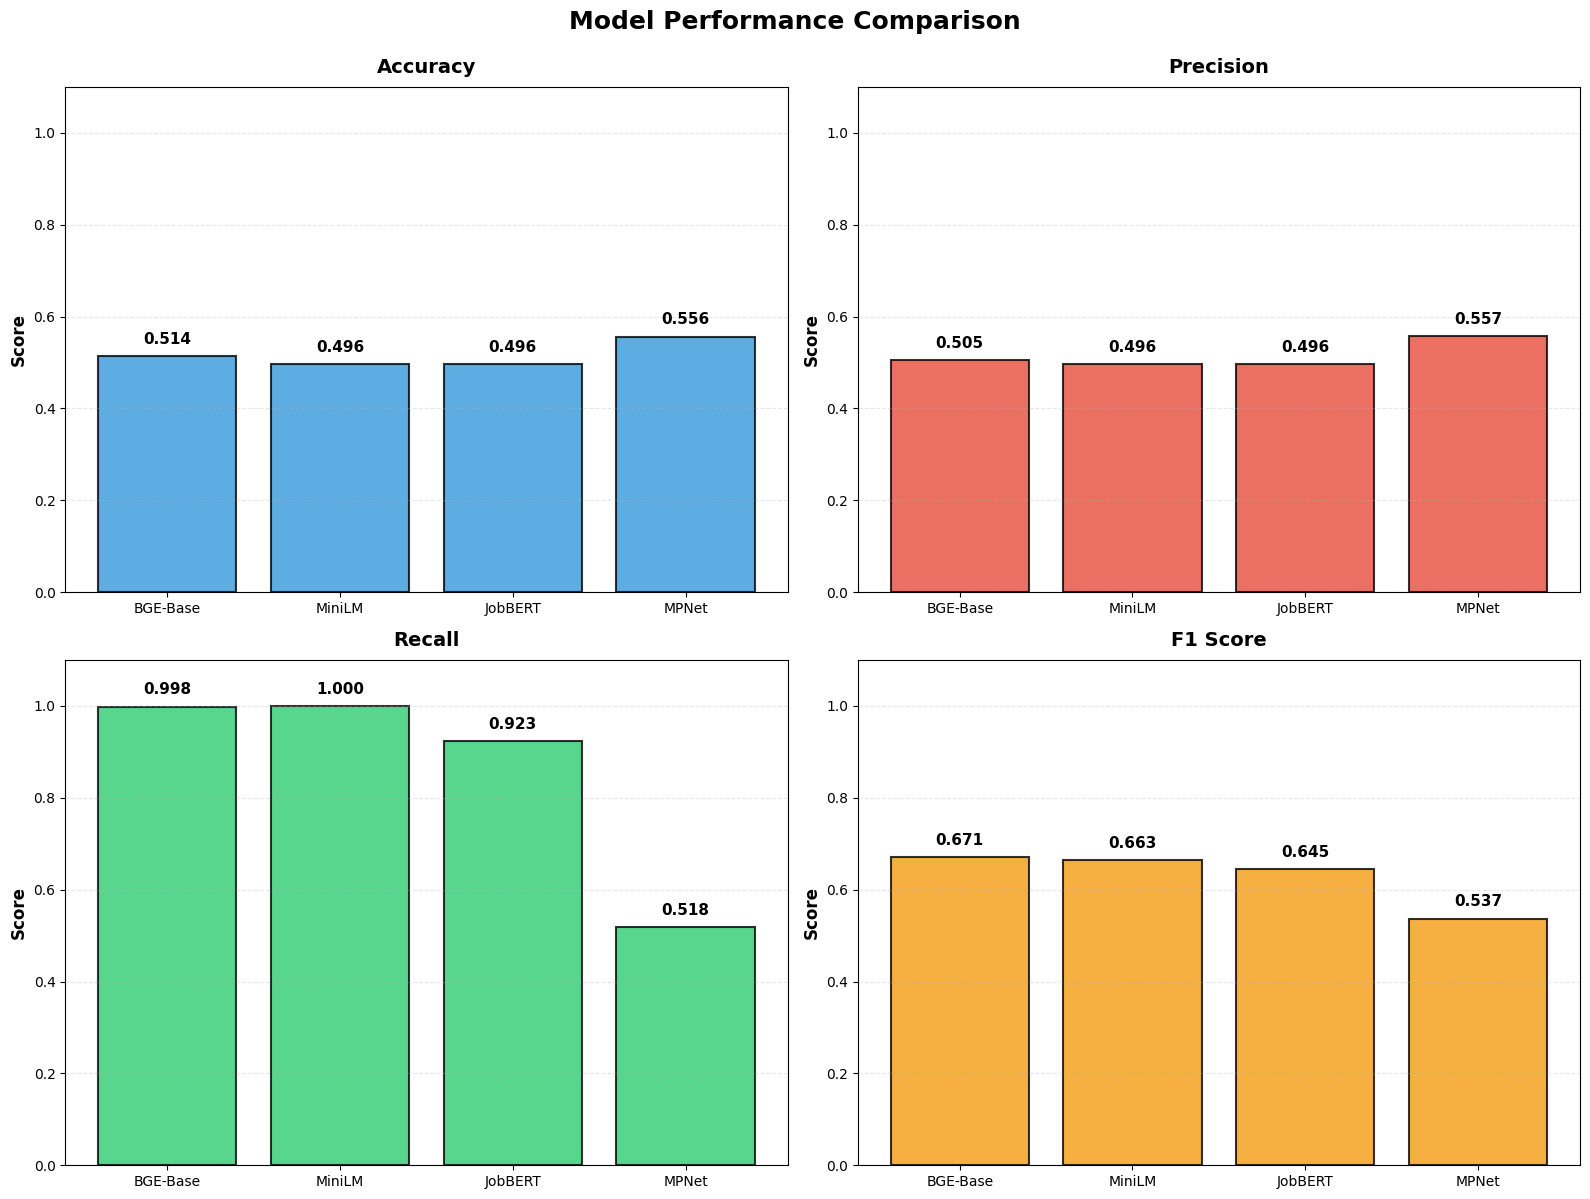

✅ Saved: f1_comparison.png


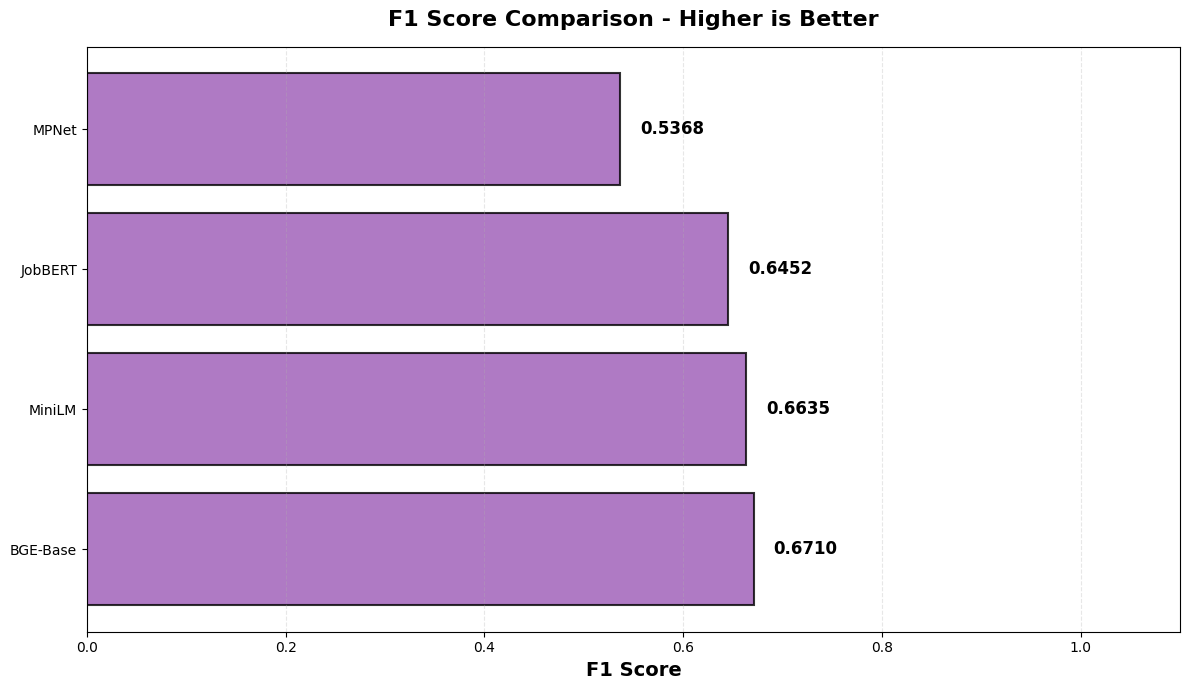


✅ All visualizations completed!

🎉 ALL DONE! Check your outputs above!


In [11]:
if len(all_results) > 0:
    
    # 1. مقارنة جميع الـ Metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Model Performance Comparison', fontsize=18, fontweight='bold', y=0.995)
    
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
    
    for idx, (metric, color) in enumerate(zip(metrics, colors)):
        ax = axes[idx // 2, idx % 2]
        
        bars = ax.bar(results_df['model_name'], results_df[metric], 
                      color=color, alpha=0.8, edgecolor='black', linewidth=1.5)
        
        ax.set_title(f'{metric.replace("_", " ").title()}', 
                     fontsize=14, fontweight='bold', pad=10)
        ax.set_ylabel('Score', fontsize=12, fontweight='bold')
        ax.set_ylim([0, 1.1])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.tick_params(axis='x', rotation=0)
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: metrics_comparison.png")
    plt.show()
    
    
    # 2. F1 Score Comparison
    fig, ax = plt.subplots(figsize=(12, 7))
    
    bars = ax.barh(results_df['model_name'], results_df['f1_score'], 
                   color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('F1 Score', fontsize=14, fontweight='bold')
    ax.set_title('F1 Score Comparison - Higher is Better', 
                 fontsize=16, fontweight='bold', pad=15)
    ax.set_xlim([0, 1.1])
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add values
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2.,
                f'{width:.4f}',
                ha='left', va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('f1_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: f1_comparison.png")
    plt.show()
    
    print("\n✅ All visualizations completed!")

else:
    print("⚠️ No results to visualize")


print("\n" + "="*80)
print("🎉 ALL DONE! Check your outputs above!")
print("="*80)